# My Approach: Heuristic Intent Distribution Exploration
I need to get an idea of how much true intents are inside my Twitter data. Doing it by keyword might prove to be a good baseline way to do this. I build off this idea, and do a heuristic clustering of my intents by trying to minimize intent intersections. I try to boil down with this method to have the most distinct and _mutually exclusive_ sets of intents so that Eve bot will be able to be trained to distinguish these intents.

I was inspired by seeing other solutions, such as the implementation by cortex, where they made a "semantic fingerprint" per intent. Obviously, the details of that are not shared, but it was enough for me to try to think of my own solution. Initially, I was going to stem off the clustering and try to manually pick out 1000 examples manually, but that is just not a smart idea and is extremely labor intensive.

This notebook is my way of getting my training data for intent classificaition.

In [4]:
import pandas as pd
print(f'pandas: {pd.__version__}')
import numpy as np
print(f'numpy: {np.__version__}')
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
# Making my visualizations pretty
sns.set_style('whitegrid')
# Combination exploration
import itertools
import yaml

# Loading back processed data
processed = pd.read_pickle('objects/processed.pkl')
print(f'\ninbound:\n{processed.head()}')

pandas: 1.0.5
numpy: 1.18.5

inbound:
                                    Processed Inbound  \
0   [new, update, i️, make, sure, download, yester...   
6   [hey, anyone, else, upgraded, io, issue, capit...   
12  [hello, internet, someone, explain, symbol, ke...   
13  [get, screenshot, say, iphonex, reserve, email...   
15  [thank, update, phone, even, slow, barely, wor...   

                                         Real Inbound  \
0   @AppleSupport The newest update. I️ made sure ...   
6   Hey @AppleSupport and anyone else who upgraded...   
12  Hello, internet. Can someone explain why this ...   
13  @AppleSupport I’ve got a screenshot saying my ...   
15  Thank you @AppleSupport I updated my phone and...   

                                        Real Outbound  
0   @115854 Lets take a closer look into this issu...  
6   @115856 Hey, let's work together to figure out...  
12  @115861 You're in the right place; we'll do al...  
13  @115863 Go ahead and send us a DM please. Let ..

## Brief Keyword Search EDA
Using this as a tool to look at Tweets.

In [16]:
# Search by keywords (single keyword filter)
keyword = 'update'

# Seeing what the processed Tweets look like
filt = [(i,j) for i,j in enumerate(processed['Processed Inbound']) if keyword in j]
filtered = processed.iloc[[i[0] for i in filt]]
print(f'{len(filtered)} Tweets contain the keyword {keyword}')
filtered

,Processed Inbound,Real Inbound,Real Outbound
0,"[new, update, i️, make, sure, download, yester...",@AppleSupport The newest update. I️ made sure ...,@115854 Lets take a closer look into this issu...
15,"[thank, update, phone, even, slow, barely, wor...",Thank you @AppleSupport I updated my phone and...,"@115864 We'd like to help, but we'll need more..."
19,"[need, software, update, urgently, battery, la...",@AppleSupport I need the software update urgen...,@115865 Hi there! What type of device are we w...
25,"[hey, last, time, download, update, freak, pho...",Hey @115858! Last time I downloaded an update ...,@115869 We're here to help. Meet us in DM and ...
38,"[iphone, yes, io, checked, update, none, avail...","@AppleSupport iPhone 6, yes ios11. Checked for...","@116102 To make sure, is iOS 11.1 showing here..."
...,...,...,...
106624,"[dear, fuck, wish, iphone, would, stop, crash,...",Dear @115858 I fucking wish my iPhone 7 would ...,@823495 We know it's important for your iPhone...
106630,"[im, upset, update, every, time, type, anythin...","im so upset over this @115858 update, every ti...",@485591 We completely understand being upset a...
106634,"[home, button, work, phone, battery, last, lit...",@115858 My home button does not work. My phone...,@823651 We want your iPhone to work as it shou...
106636,"[whenever, new, iphone, get, launch, old, mode...",@115858 why is it whenever a new iphone gets l...,@823679 Thanks for reaching out. We know how i...


# My Intents:

<img src="visualizations/intent_list.png" alt="Drawing" style="width: 300px;"/>

This following cell represents the journey that I had of finding intents. In the end, everything below it is to inform the choice for this dictionary, and subsequently creating my training data. It reduced substantially when I realized that I could combine this with Named Entity Recognition as well.

You'll notice it doesn't contain everything, and that's because some intents are not in my training data - they have to be manually created. Examples of this is greeting: this training data will not contain just Tweets with just 'hi', they almost always contain multiple intents.

In [70]:
# Post-hoc Intents: I find the keywords that is associated with intent and search based on these keywords

# Version 1 - Initial Mockup: Making a dictionary to store intents and the predefined responses

intents = {"Greeting": ["Hi there!","Hello"], 
 "Closing":"Thanks for talking", 
 "Promotion":"",
           "Scenarios": {'Last payment': "", "Account details":"", 
                         "Account confirmation": ""},
    "Location": ""}

# Version 2 - Just for showing progress
intents = {'greeting': ['hi', 'hello', 'hey','yo'], 'app': ['app', 'application'],
          'iphone': ['iphone', 'i phone'], 'icloud': ['icloud', 'i cloud'],
          'ios': ['io'], 'battery': ['battery'], 'watch': ['watch'], 'mac': 
           ['mac', 'macbook', 'laptop', 'computer'], 'update': ['update'],
          'troubleshooting': ['problem', 'trouble', 'error'],
          'settings': ['settings', 'setting'], 'music': ['music', 'song', 'playlist'],
          'payment': ['credit','card','payment','pay'], 'bug':['bug'], 'watch': ['tv', 'show'],
          'network': ['internet','connection','network']}

# Intents that require all words within it to be contained in the list (alternative filtering method)
intents_all = {'ios update': ['io', 'update'], 'app update': ['app','update']}

# Version 3
intents = {'update': ['update'], 'battery': ['battery', 'power'], 'forgot_password':['password','account','login'],
          'repair':['repair','fix','broken'], 'lost_replace': ['replace','lost','gone','missing','trade','trade-in'], 
           'payment': ['credit','card','payment','pay']}

# Storing it to YAML file
with open('objects/intents.yml', 'w') as outfile:
    yaml.dump(intents, outfile, default_flow_style=False)

print('INTENTS FOR KEYWORD EDA BELOW:\n ------------------------')
for i in intents.items():
    print('Intent: {} \n   Keywords: {}'.format(i[0], " + ".join(i[1])))

INTENTS FOR KEYWORD EDA BELOW:
 ------------------------
Intent: update 
   Keywords: update
Intent: battery 
   Keywords: battery + power
Intent: forgot_password 
   Keywords: password + account + login
Intent: repair 
   Keywords: repair + fix + broken
Intent: lost_replace 
   Keywords: replace + lost + gone + missing + trade + trade-in
Intent: payment 
   Keywords: credit + card + payment + pay


### Useful functions I made. Will be very useful for the intent exploratory analysis.

In [71]:
# Three different ways to filter out Tweets based on Keywords
# 1.
def get_key_tweets(series, keywords):
    ''' Takes as input the list of keywords and outputs the Tweets that contains at least
    one of these keywords '''
    keyword_tweets = []
    for tweet in series:
        # Want to check if keyword is in tweets
        for keyword in keywords:
            if keyword in tweet:
                keyword_tweets.append(tweet)
    return keyword_tweets

# 2. Making a function that filters to Tweets that needs to have ALL the keywords
def all_key_tweets(series, keywords):
    ''' Takes as input the list of keywords and outputs the Tweets have all the keywords'''
    keyword_absent_tweets = []
    for tweet in series:
        # Want to check if keyword is not in tweets
        if all(item in tweet for item in keywords):
            keyword_absent_tweets.append(tweet)
    return keyword_absent_tweets

# 3. Making a function that filters to tweets that DONT contain any of the keywords
def key_absent_tweets(series, keywords):
    ''' Takes as input the list of keywords and outputs the Tweets that don't contain any
    of these keywords '''
    keyword_absent_tweets = []
    for tweet in series:
        # Want to check if keyword is not in tweets
        if not any(item in tweet for item in keywords):
            keyword_absent_tweets.append(tweet)
    return keyword_absent_tweets

# Getting a list of all my keywords so far
all_keywords = []
for keywords in intents.values():
    for keyword in keywords:
        all_keywords.append(keyword)      
        

def only_key_tweets(series, keywords):
    ''' Uses the all_keywords '''
    kept = list()
    for tweet in series:
        # Check
        if all(elem in tweet for elem in keywords):
            kept.append(tweet)
    return pd.Series(kept)
        
def to_set(l):
    ''' In order to make the Tweets a set to check for intersections, we need
    to make them immutable by making it a tuple because sets only accept immutable
    elements '''
    return set([tuple(row) for row in l])


### Intent Visualization

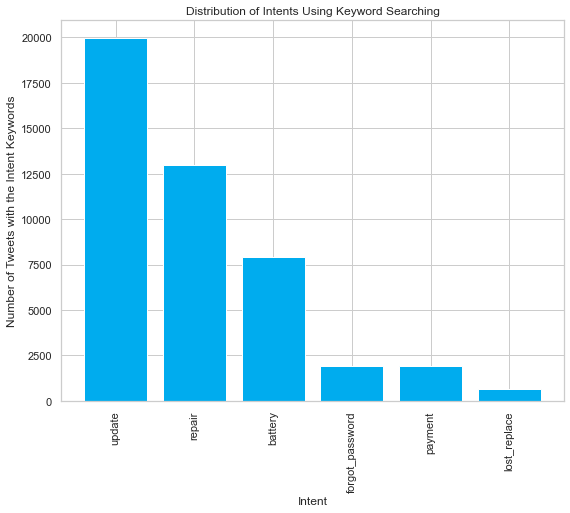

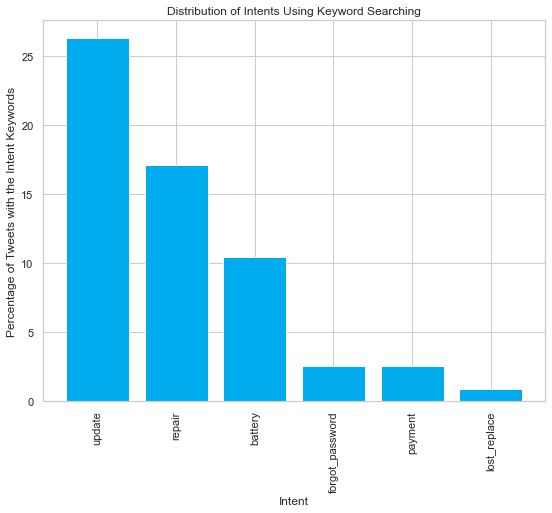

In [72]:
# Using the function above to visualize the distribution of intents in my dataset

intent_lengths = [len(get_key_tweets(processed_inbound, intents[intent])) for intent in intents.keys()]
keyword = pd.DataFrame({'intents': list(intents.keys()), 'intent_lengths': intent_lengths}).sort_values('intent_lengths', ascending = False)

# Visualization
plt.figure(figsize=(9,7))
plt.bar(keyword['intents'], keyword['intent_lengths'], color = '#00acee')
plt.title('Distribution of Intents Using Keyword Searching')
plt.xlabel('Intent')
plt.xticks(rotation=90)
plt.ylabel('Number of Tweets with the Intent Keywords')
plt.show()

# Proportions visualization
plt.figure(figsize=(9,7))
plt.bar(keyword['intents'], keyword['intent_lengths'] * 100 / 75879, color = '#00acee')
plt.title('Distribution of Intents Using Keyword Searching')
plt.xlabel('Intent')
plt.xticks(rotation=90)
plt.ylabel('Percentage of Tweets with the Intent Keywords')
# Saving
plt.savefig('visualizations/intent_distribution_keyword.png')
plt.show()

In [73]:
# Seeing precise numeric counts
keyword

,intents,intent_lengths
0,update,19942
3,repair,12996
1,battery,7896
2,forgot_password,1928
5,payment,1911
4,lost_replace,627


From here it seems like we won't have enough for the last 2 intents to get 1000, but that's fine because I can just duplicate them perhaps later.

I also did an alternative filter for the number of Tweets that contain at least one question make. In this exploration, I found that from the total number of 75879, 27373 of these contain at least 1 question mark (36.1%).

### Combination Exploration

Here, I want to see how many Tweets overlap between different categories that was searched. If there is too much overlap between the intents, it means that we can label two intents for that particular Tweet. I think that would still work, although that would mean that we would need to see how we can reply to double intents.

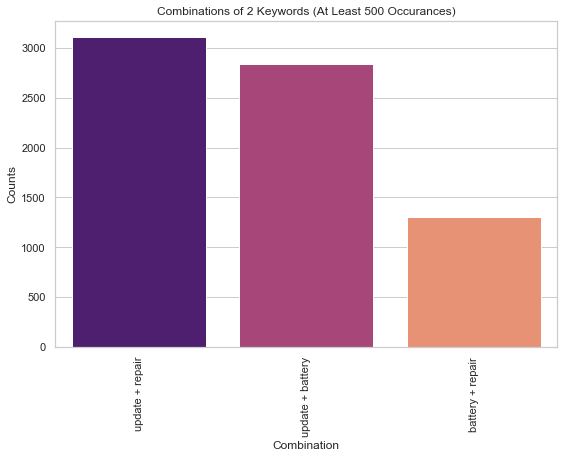

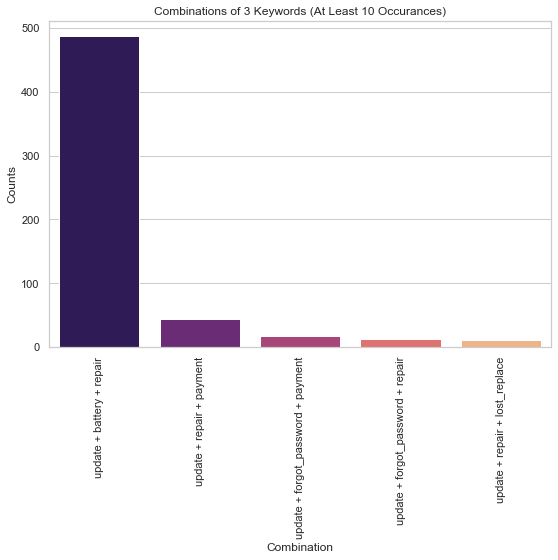

Not enough 4-combinations (Thres = 5)
Not enough 5-combinations (Thres = 5)


<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [75]:
# Initializing all the thresholds for min amount of combination appearances
thres = [500,10,5,5]

# Intent Tweets have all the keys, and as the value contains all the tweets that contain that key, as a set
intent_tweets = {}
for key in intents.keys():
    intent_tweets[key] = to_set(get_key_tweets(processed_inbound,intents[key]))

# Iterating through all pairs, and getting how many Tweets intersect between the pair
keyword_overlaps = {}

# COMBINATIONS OF 2

# Each i returns a tuple containing a pair of length r, which in this case is 2
for i in list(itertools.combinations(list(intents.keys()),2)):
    a = to_set(intent_tweets[i[0]])
    b = to_set(intent_tweets[i[1]])
    # Inserting pair to dictionary
    keyword_overlaps[f"{i[0]} + {i[1]}"] = len(a.intersection(b))

# Filtering to just the significant ones, which I define as greater than 100
combs = []
counts = []
for i in keyword_overlaps.items():
    if i[1] > thres[0]:
        combs.append(i[0])
        counts.append(i[1])

# Visualizing as well
v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
plt.figure(figsize=(9,6))
sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
plt.title(f'Combinations of 2 Keywords (At Least {thres[0]} Occurances)')
plt.xticks(rotation=90)
plt.show()

# COMBINATIONS OF 3
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 3
    for i in list(itertools.combinations(list(intents.keys()),3)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]}"] = len(a.intersection(b).intersection(c))

    # Filtering to just the significant ones, which I define as greater than 100
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[1]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
    plt.figure(figsize=(9,6))
    sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
    plt.title(f'Combinations of 3 Keywords (At Least {thres[1]} Occurances)')
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f'Not enough 3-combinations (Thres = {thres[1]})')
    
# COMBINATIONS OF 4
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 4
    for i in list(itertools.combinations(list(intents.keys()),4)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        d = to_set(intent_tweets[i[3]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]} + {i[3]}"] = len(a.intersection(b).intersection(c).intersection(d))

    # Filtering to just the significant ones, which I define as greater than 10
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[2]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
    plt.figure(figsize=(9,6))
    sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
    plt.title(f'Combinations of 4 Keywords (At Least {thres[2]} Occurances)')
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f'Not enough 4-combinations (Thres = {thres[2]})')

# GROUPS OF 5
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 5
    for i in list(itertools.combinations(list(intents.keys()),5)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        d = to_set(intent_tweets[i[3]])
        e = to_set(intent_tweets[i[4]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]} + {i[3]} + {i[4]}"] = len(a.intersection(b).intersection(c).intersection(d).intersection(e))

    # Filtering to just the significant ones, which I define as greater than 5
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[3]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
    plt.figure(figsize=(9,6))
    sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
    plt.title(f'Combinations of 5 Keywords (At Least {thres[3]} Occurances)')
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f'Not enough 5-combinations (Thres = {thres[3]})')

We see here in the combinations of 4 that it's really obvious what the customer want's to ask us. The highest one that occured 407 times is ('iphone recs + ios + battery + update') - this are the customers that want a recommendation for their iPhone about their ios, and it's something about an update.

Here even see some for combinations of 5.

Where better than to see what intents are available other than Apple's own [@applesupport](https://twitter.com/AppleSupport) Twitter page?

* We see that update is generally present across many combinations
* Most of the intents are usually a combination of one other one!

We can see that based on the absolute value of the number of Tweets that are similar, we won't really have much trouble finding 1000 training examples for each intent category - especially for update! It might be a good idea as well to break down the higher occurances to more nuanced and distinct categories. Also, I generally want to use intents that have over 1000 Tweets, and the good news is that most of the intents have more than 1000 Tweets each.

# Special Cases
That I want to test out and might be useful.

In [24]:
# I wanted to group iOS update into one intent. 
# But since ios and update occured a lot other I put them together into one intent group. 

print('app intents without ios: {}'.format(len(key_absent_tweets(get_key_tweets(processed_inbound, intents['app']), ['io']))))
key_absent_tweets(get_key_tweets(processed_inbound, intents['app']), ['io']);

# Exploration of combinations and "purity" of a cluster
print('both ios and update appears: {}'.format(6000))
print('just ios: {}'.format(len(get_key_tweets(processed_inbound, intents['ios']))))
print('ios but no update: {}'.format(len(get_key_tweets(processed_inbound, intents['ios'])) - 6000))

app intents without ios: 3352


### I want to look for all the tweets I have not accounted for in my heuristic search
Probably the most useful filter is this.

In [25]:
# Using the key absent function
key_absent_tweets(processed['Processed Inbound'].iloc, all_keywords)

[['get', 'screenshot', 'say', 'iphonex', 'reserve', 'email', 'say', 'happen'],
 ['find', 'option', 'get', 'it', 'always', 'play'],
 ['i️', 'keep', 'change', 'i️', 'stop', '️', 'anybody'],
 ['get',
  'white',
  'screen',
  'nothing',
  'load',
  'short',
  'time',
  'close',
  'crash',
  'thanks',
  'reply'],
 ['change',
  'ringer',
  'volume',
  'button',
  'whose',
  'dumb',
  'idea',
  'change',
  'still',
  'job'],
 ['apps', 'epilepsy', 'detect', 'seizure', 'thanks', 'advance'],
 ['creates',
  'amaze',
  'technology',
  'talk',
  'text',
  'still',
  'mess',
  'type',
  'fixyourcrap'],
 ['excuse',
  'someone',
  'explain',
  'type',
  'i️',
  'alone',
  'i️',
  'get',
  'question',
  'mark'],
 ['yes',
  'sorry',
  'i️',
  'watch',
  'video',
  'beta',
  'i️',
  'type',
  'letter',
  'eye',
  'i️',
  'happens'],
 ['virginmedia',
  'try',
  'twice',
  'completely',
  'new',
  'mail',
  'one',
  'save',
  'though',
  'odd'],
 ['long', 'take', 'usually', 'account', 'recovery', 'get', 'b

From here, I get inspiration to account for:
* Settings
* Apple Music
* Phone
* Credit card

In [146]:
only_key_tweets(processed_inbound, intents_all['ios update'])

0       [iphone, yes, io, checked, update, none, avail...
1       [update, io, iphone, icloud, backup, greyed, c...
2       [sort, thanks, io, update, need, change, hard,...
3       [top, bar, every, time, open, message, se, upd...
4       [i, have, update, io, shall, check, wifi, hots...
                              ...                        
5995    [iphone, believe, run, version, io, phone, wou...
5996    [update, new, io, speaker, work, play, music, ...
5997    [every, time, bring, new, phone, release, io, ...
5998    [reason, iphone, plus, extremely, low, call, v...
5999    [anyone, iphone, issue, phone, freeze, randoml...
Length: 6000, dtype: object

In [147]:
only_key_tweets(processed_inbound, ['app'])

0       [hey, anyone, else, upgraded, io, issue, capit...
1         [app, still, longer, able, control, lockscreen]
2       [iphone, yes, io, checked, update, none, avail...
3         [phone, app, work, thank, update, iphone, ipod]
4       [bug, calendar, app, fix, upgraded, io, still,...
                              ...                        
4157    [itunes, open, although, app, store, warn, can...
4158    [another, iphone, update, still, fix, podcast,...
4159    [fix, io, fuckover, kill, phone, garage, door,...
4160    [hey, listen, one, podcast, order, continuousl...
4161    [dear, fuck, wish, iphone, would, stop, crash,...
Length: 4162, dtype: object

In [166]:
keyword

,intents,intent_lengths
8,update,19922
2,iphone,16788
4,ios,14706
5,battery,7339
0,greeting,6843
1,app,4352
9,troubleshooting,4238
11,music,3779
7,mac,3367
13,bug,2331


Settings might not be the best intent to try on.

In [151]:
# Inspecting the Tweets with that specific keyword
len(get_key_tweets(processed_inbound, intents['greeting'])), 27373/75879

(6843, 0.36074539727724403)

In [152]:
get_key_tweets(processed_inbound, intents['app'])

[['hey',
  'anyone',
  'else',
  'upgraded',
  'io',
  'issue',
  'capital',
  'i️',
  'mail',
  'app',
  'put'],
 ['app', 'still', 'longer', 'able', 'control', 'lockscreen'],
 ['iphone',
  'yes',
  'io',
  'checked',
  'update',
  'none',
  'available',
  'swipe',
  'close',
  'app',
  'several',
  'time',
  'restart'],
 ['phone', 'app', 'work', 'thank', 'update', 'iphone', 'ipod'],
 ['bug', 'calendar', 'app', 'fix', 'upgraded', 'io', 'still', 'crash', 'io'],
 ['i',
  'have',
  'also',
  'force',
  'app',
  'close',
  'background',
  'reopen',
  'dice'],
 ['wife',
  'make',
  'mistake',
  'update',
  'revert',
  'back',
  'password',
  'keeper',
  'app',
  'dead',
  'can',
  'not',
  'access',
  'password'],
 ['io',
  'never',
  'release',
  'many',
  'bug',
  'statusbar',
  'randomly',
  'disappears',
  'facebook',
  'app'],
 ['attempt',
  'open',
  'twitter',
  'app',
  'complain',
  'io',
  'mess',
  'iphone',
  'slow',
  'life'],
 ['happens', 'close', 'whatsapp', 'happen', 'app', 

In [160]:
intents['greeting']

['hi', 'hello', 'hey', 'yo']

In [161]:
processed_inbound.iloc[0:10]

0     [new, update, i️, make, sure, download, yester...
4     [hey, anyone, else, upgraded, io, issue, capit...
9     [hello, internet, someone, explain, symbol, ke...
10    [get, screenshot, say, iphonex, reserve, email...
12    [thank, update, phone, even, slow, barely, wor...
14    [need, software, update, urgently, battery, la...
15         [hi, go, youtube, lose, do, thanks, support]
17    [hey, last, time, download, update, freak, pho...
19      [app, still, longer, able, control, lockscreen]
21           [need, something, battery, life, suck, as]
dtype: object

## Captured intents
(This is just another version of what I thought the intents would be - you could see there are multiple versions of these because it's an iterative heuristic optimization process) - It actually took me a while to find a good guideline of how to bucket intents.

1. Greeting
2. App recommendations
    * Need to tag the actual appication we want
    * Need to tag the problem
3. Hardware recommendations
    * Phone hardware issue
    * Battery health
6. ICloud photos
7. Apple watch
8. Software (iOS)/ update bugs
9. Statement (not really asking for anything, it is just giving a statement about something) - If possible, I would like to remove these because they are not really that useful to me.
    * Opinions
    * Complaint
    * Thinking about this point further, it might be useful to include question marks in the data because that encodes useful information about whether or not a customer is making a question or not.
10. Want to purchase
11. Gratitude/Closing